In [169]:
import pandas as pd
import geopandas as gp
import os
import numpy as np
import matplotlib
import fiona
import pathlib
import glob

In [178]:
#### SET FILE PATHS ####

boundary_path = "/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Boundary/SP clipping area.shp"
clip_path = "/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Clipped"
raw_path = "/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Raw"
project_path = "/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Projected"

In [179]:
# set project CRS
crs = 2926

# set boundary
boundary = gp.read_file(boundary_path)
boundary_project = boundary.to_crs(crs)
boundary_project.to_file(boundary_path)

In [191]:
# project to project's crs and clip to boundary

files = glob.glob(raw_path + '/**/*.shp', recursive = True)

for f in files:
    file_name = os.path.basename(f)[:-4]
    print(f'processing {file_name}')
    gdf = gp.read_file(f)
    gdf_project = gdf.to_crs(crs)
    gdf_project.to_file(os.path.join(project_path, f'{file_name}_projected.shp'))
    print(os.path.join(project_path, f'{file_name}_projected.shp'))

    gdf_clip = gp.clip(gdf_project, boundary)
    gdf_clip.to_file(os.path.join(clip_path, f'{file_name}_clipped.shp'))
    print(os.path.join(clip_path, f'{file_name}_clipped.shp'))


/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Raw/Building_Outlines_2015/Building_Outlines_2015.shp
/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Projected/Building_Outlines_2015_projected.shp
/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Clipped/Building_Outlines_2015_clipped.shp
/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Raw/Seattle_Streets/Seattle_Streets.shp
/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Projected/Seattle_Streets_projected.shp
/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Clipped/Seattle_Streets_clipped.shp
/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Raw/Street_Network_Database_(SND)-20230505T014240Z-001/Street_Network_Database_(SND)/Street_Network_Database_(SND).shp
/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Projected/Street_Network_Database_(SND)_projected.shp
/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Clipped/Street_Network_Database_(SND)_clipped.shp


STREET ANALYSIS

In [192]:
# find average street width by functional class
#### TODO- should this be within our zone or across the whole data set?

streets = gp.read_file("/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Raw/Seattle_Streets/Seattle_Streets.shp")
streets = streets.to_crs(crs)


In [236]:
streets.SURFACEWID.value_counts()
print('number of roads with no width: ', len(streets[streets.SURFACEWID == 0]))

streets['ARTCLASS'] = streets['ARTCLASS'].map(str)

# backfill data by average width for each functional class
streets_wid = streets[['ARTCLASS','SURFACEWID']]

# remove rows = 0 before finding average
streets_wid = streets_wid[streets_wid.SURFACEWID != 0]
streets_wid.SURFACEWID.value_counts()

# calculate average by arterial class and surface type
streets_wid_avg = streets_wid.groupby(['ARTCLASS']).mean()
streets_wid_avg.reset_index(inplace = True)
streets_wid_avg['ARTCLASS'] = streets_wid_avg['ARTCLASS'].map(str).str[0]

## histogram of artclass = 0 surface width
# IQR of not designated roads with a surface width ranges from 22-25. min = 8 and max = 84
# streets[streets['ARTCLASS']=='0.0'][streets['SURFACEWID']!= 0]['SURFACEWID'].describe()

number of roads with no width:  3633


In [255]:
streets_clipped = "/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Projected/seattle_streets_clipped_projected.shp"

streets_clipped_gdf = gp.read_file(streets_clipped)
streets_clipped_gdf = streets_clipped_gdf.to_crs(crs)
streets_clipped_gdf['ARTCLASS'] = streets_clipped_gdf['ARTCLASS'].map(str)


In [256]:
# backfill data in the CLIPPED AND PROJECTED FILE by average width for each functional class
# NOTE: arterial class == 9 has one feature with surface width == 0. there is no backfilled data for this road
streets_bfill = pd.merge(left = streets_clipped_gdf, right = streets_wid_avg, how = 'left', left_on = 'ARTCLASS', right_on = 'ARTCLASS')
streets_bfill[['OBJECTID','ARTCLASS','UNITDESC','ARTDESCRIP','SURFACEWID_x','SURFACEWID_y','geometry']]
streets_bfill['width_upd'] = np.where(streets_bfill['SURFACEWID_x'] == 0, streets_bfill['SURFACEWID_y'], streets_bfill['SURFACEWID_x'])

In [257]:
# buffer by the surface width
streets_bfill['geometry'] = streets_bfill.buffer(distance = streets_bfill['width_upd'])
columns = ['OBJECTID','ARTCLASS','UNITDESC','STNAME_ORD','ARTDESCRIP','SURFACEWID_x','width_upd','geometry']


/tmp/ipykernel_431/3488204830.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  streets_bfill[columns].to_file("/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Processed/seattle_streets_buffer.shp")


In [259]:
streets_bfill[columns].to_file("/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Processed/seattle_streets_buffer.shp")
streets_bfill.dissolve().boundary.to_file("/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Processed/seattle_streets_buffer_outlines.shp")

/tmp/ipykernel_431/1532605591.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  streets_bfill[columns].to_file("/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Processed/seattle_streets_buffer.shp")


In [109]:
## looking at SND network to compare against seattle streets
SND = gp.read_file("/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Raw/Street_Network_Database_(SND)-20230505T014240Z-001/Street_Network_Database_(SND)/Street_Network_Database_(SND).shp")

In [112]:
# TODO: need to look up what the arterial class widths are
SND.columns
SND['ARTERIAL_C'].value_counts()

ARTERIAL_C
0    24818
1     8482
6      382
5      369
4      216
Name: count, dtype: int64

BUILDING ANALYSIS

In [115]:
buildings = gp.read_file("/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Projected/buildings_2015_clipped_projected.shp")

In [263]:
buildings.to_crs(crs).to_file("/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Projected/buildings_2015_clipped_projected.shp")

SHAPE_Area
26068.058444    2
191.249730      2
1899.627866     1
2142.086791     1
1433.509470     1
               ..
103.478245      1
251.598456      1
76.055774       1
78.800585       1
564.278786      1
Name: count, Length: 29668, dtype: int64

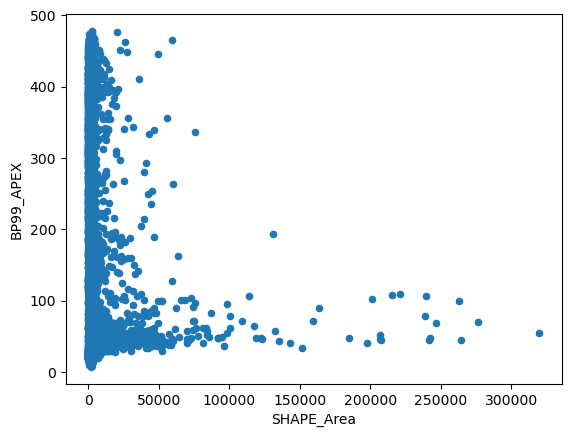

In [135]:
buildings.columns
# 5k buildings do not have building heights
# buildings['BP99_APEX'].value_counts()

# scatter plot of area x building apex for grouping and backfilling
buildings['SHAPE_Area'].describe()
buildings_scatter = buildings[buildings.BP99_APEX!=0]
buildings_scatter = buildings_scatter[buildings_scatter.SHAPE_Area!=0]
buildings_scatter.plot.scatter('SHAPE_Area','BP99_APEX')

In [ ]:
#TODO find default height and backfill for any height < ???